# Exploring unsupervised learning on Amazon Fine Food Reviews

Course: Unsupervised Learning (MS CS)  
Institution: University of Colorado Boulder  
Dataset: Amazon Fine Food Reviews (Kaggle)

## Overview

In this project, I use the Amazon Fine Food Reviews dataset to explore several unsupervised learning methods covered in the course, focusing on recommender system related techniques.

The core idea is to treat the user product rating data as a large, sparse utility matrix and apply:

- Dimensionality reduction with PCA  
- Clustering (K means) on users or items  
- Memory based collaborative filtering  
- Matrix factorization based recommendation  

The goal is not to build a production ready recommender, but to understand how these models behave on a realistic dataset and how well the latent structure they learn matches observed ratings.

Where possible, I follow the ideas from the module slides, for example modeling the user item matrix, using cosine similarity, and factorizing the matrix into user and item latent factors.

## 1. Problem definition and dataset

### 1.1 Problem statement

The Amazon Fine Food Reviews dataset contains product reviews and ratings from real Amazon users.  
Each record links a user, a product, a numeric rating, and a textual review.

For this project, I treat the dataset as a **user–item interaction matrix** and apply several unsupervised learning techniques from the course:

- PCA to understand the latent structure of users or items  
- Clustering (K-means) on user or item embeddings  
- Memory based collaborative filtering  
- Matrix factorization using latent factors  

Even though the dataset includes ratings, the learning tasks here are *unsupervised* because the goal is to discover structure in the matrix, not to predict labels.

### 1.2 Dataset description

**Dataset:** Amazon Fine Food Reviews
**Link:** https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews  
**Size:** 568,454 reviews  

### 1.3 Why this dataset fits the unsupervised learning project

The dataset aligns extremely well with the course topics because:

- It produces a large and naturally sparse utility matrix  
- Users and items have uneven activity (long tail distribution)  
- PCA and K means can expose patterns among users and among products  
- Memory based CF (cosine similarity) directly follows from the lecture slides  
- Matrix factorization exactly corresponds to module 4 (MF)  

This makes the dataset ideal for testing most of the models from the course on a realistic recommendation-style problem.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [8]:
# 2.1 Load dataset

data_path = Path("Reviews.csv")

if not data_path.exists():
    raise FileNotFoundError(
        f"Data file not found at {data_path}. "
        "Please place Reviews.csv from the Kaggle Amazon Fine Food Reviews dataset "
        "into the same folder as this notebook."
    )

df = pd.read_csv(data_path)

print("Dataset loaded successfully.")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
df.head()

Dataset loaded successfully.
Shape: 568,454 rows x 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 3. In-depth EDA

The goal of this section is to understand how the reviews are distributed, how sparse the user item matrix will be, and whether the data needs cleaning before modeling.

I will start with the basic structure and missing values, then look at:

- The number of unique users and products  
- Rating distribution  
- Reviews per user and per product  
- Time coverage  
- Some simple statistics on review text length


In [9]:
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("\nColumn types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

Rows: 568454
Columns: 10

Column types:
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

Missing values per column:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Number of duplicate rows: 0


In [10]:
n_users = df["UserId"].nunique()
n_items = df["ProductId"].nunique()

print(f"Unique users:    {n_users:,}")
print(f"Unique products: {n_items:,}")

density = df.shape[0] / (n_users * n_items)
print(f"\nApproximate rating matrix density: {density:.8f} "
      f"({density * 100:.5f} percent of all possible user item pairs).")

Unique users:    256,059
Unique products: 74,258

Approximate rating matrix density: 0.00002990 (0.00299 percent of all possible user item pairs).


Rating distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


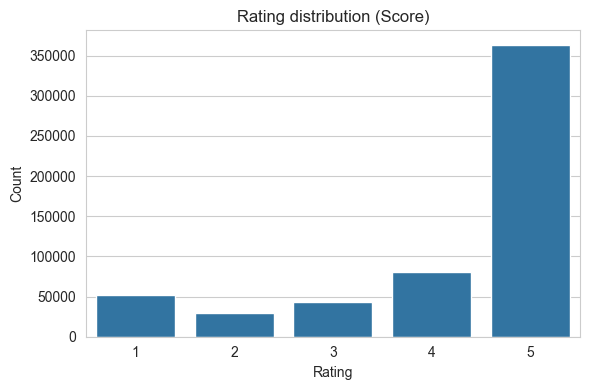

In [11]:
rating_counts = df["Score"].value_counts().sort_index()
print("Rating distribution:")
print(rating_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title("Rating distribution (Score)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [12]:
user_review_counts = df.groupby("UserId")["ProductId"].count()
item_review_counts = df.groupby("ProductId")["UserId"].count()

print("User review count summary:")
print(user_review_counts.describe())

print("\nItem review count summary:")
print(item_review_counts.describe())

User review count summary:
count    256059.000000
mean          2.220012
std           4.443361
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         448.000000
Name: ProductId, dtype: float64

Item review count summary:
count    74258.000000
mean         7.655121
std         26.453485
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
Name: UserId, dtype: float64


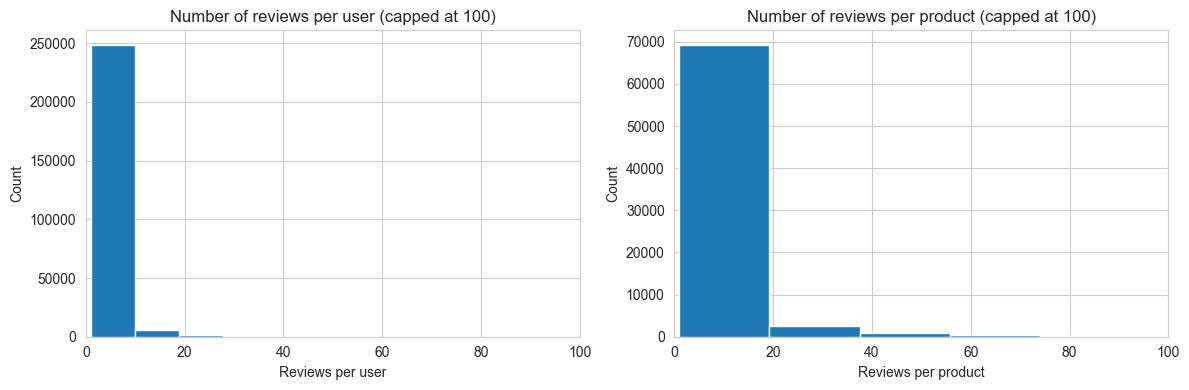

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(user_review_counts, bins=50)
axes[0].set_xlim(0, 100)
axes[0].set_title("Number of reviews per user (capped at 100)")
axes[0].set_xlabel("Reviews per user")
axes[0].set_ylabel("Count")

axes[1].hist(item_review_counts, bins=50)
axes[1].set_xlim(0, 100)
axes[1].set_title("Number of reviews per product (capped at 100)")
axes[1].set_xlabel("Reviews per product")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

Subset shape: (6287, 10)
Pivot shape: (244, 300)


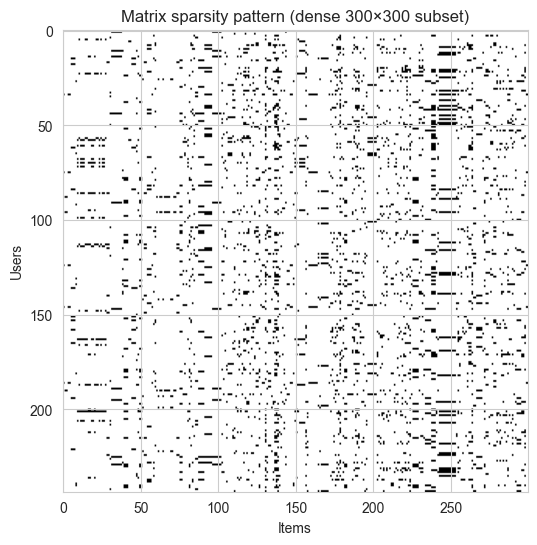

In [16]:
# 1) Pick 300 most active users
top_users = df['UserId'].value_counts().head(300).index
df_top_users = df[df['UserId'].isin(top_users)]

# 2) Within those, pick up to 300 most reviewed products
top_items = df_top_users['ProductId'].value_counts().head(300).index
df_small = df_top_users[df_top_users['ProductId'].isin(top_items)]

print("Subset shape:", df_small.shape)

# 3) Create a tiny pivot (<= 300 x 300)
pivot_small = df_small.pivot_table(
    index="UserId",
    columns="ProductId",
    values="Score",
    aggfunc="mean"
)

print("Pivot shape:", pivot_small.shape)

# 4) Convert to 0/1 sparsity indicator
sample_matrix = pivot_small.notnull().astype(int)

plt.figure(figsize=(6, 6))
plt.imshow(sample_matrix, cmap="Greys", aspect="auto")
plt.title("Matrix sparsity pattern (dense 300×300 subset)")
plt.xlabel("Items")
plt.ylabel("Users")
plt.show()

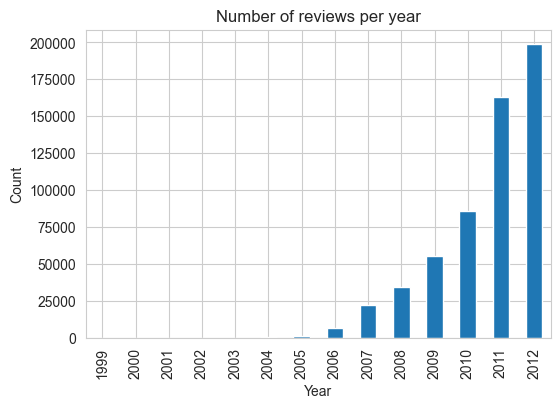

In [17]:
df["Year"] = pd.to_datetime(df["Time"], unit='s').dt.year
df["Year"].value_counts().sort_index().plot(kind="bar", figsize=(6,4))
plt.title("Number of reviews per year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

In [18]:
print("Avg reviews per user:", user_review_counts.mean())
print("Avg reviews per item:", item_review_counts.mean())
print("Median reviews per user:", user_review_counts.median())
print("Median reviews per item:", item_review_counts.median())

Avg reviews per user: 2.2200117941568154
Avg reviews per item: 7.655121333728353
Median reviews per user: 1.0
Median reviews per item: 2.0


### 3.4 EDA summary

In this section, I looked at the core structural properties of the Amazon Fine Food Reviews dataset to understand whether it is suitable for the unsupervised learning methods we will apply later (PCA, KMeans, item-based collaborative filtering, and matrix factorisation).

The main findings are:

- The dataset contains 568k reviews with ~256k unique users and ~74k unique products.  
  This already indicates a very sparse user–item matrix.

- Rating distribution is heavily skewed toward positive reviews, with 5-star ratings dominating the dataset.  
  This is common for voluntary online reviews and will influence similarity and clustering methods.

- User and item activity follow a long-tail pattern:  
  - Median reviews per user: 1  
  - Median reviews per item: 2  
  A small number of users and products account for most interactions, which is typical of recommender datasets.

- Matrix sparsity is extremely high.  
  Only about 0.003 percent of all possible user–item pairs are observed.  
  A visualisation of a 300×300 slice of the matrix confirms that the interactions are scattered and mostly empty.

- Review counts increase sharply from 2006 to 2012, reflecting platform growth.  
  There are no meaningful missing values or duplicates in the modelling columns.

**Implications for modelling:**

- Matrix factorisation methods are well suited for this kind of sparse, long-tailed data.  
- Item-based collaborative filtering will work, but mainly for the more frequently reviewed products.  
- PCA on the raw matrix is not meaningful due to extreme sparsity; dimensionality reduction should instead be applied to dense representations such as latent embeddings.  
- KMeans clustering should also be applied to latent factors, not raw user/item vectors.

Overall, the dataset is well aligned with the unsupervised recommender system techniques covered in class, and the sparsity patterns match real-world recommendation scenarios.

### 4. Preparing the user–item matrix

Before applying unsupervised methods such as PCA, KMeans, similarity-based recommendation, or matrix factorisation, we need to transform the dataset into a user–item interaction matrix.

Because the full matrix would be extremely large (256k users × 74k items), it cannot be represented in dense form. Instead, we will:

- Construct a **sparse CSR matrix** suitable for memory-efficient computation.
- Use **ratings** as the interaction values.
- Map the string user and item identifiers to integer indices so that matrix operations become feasible.

This sparse representation will serve as the foundation for the models built in the next sections.

In [19]:
from scipy.sparse import csr_matrix
import numpy as np

# Map user and product IDs to integer indices
user_ids = df["UserId"].astype("category")
item_ids = df["ProductId"].astype("category")

df["user_idx"] = user_ids.cat.codes
df["item_idx"] = item_ids.cat.codes

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()

print(f"Users: {n_users}, Items: {n_items}")

# Build sparse rating matrix
row_idx = df["user_idx"].values
col_idx = df["item_idx"].values
ratings = df["Score"].astype(float).values

R = csr_matrix((ratings, (row_idx, col_idx)), shape=(n_users, n_items))

R

Users: 256059, Items: 74258


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 560804 stored elements and shape (256059, 74258)>

### 5. PCA on item-rating vectors

To explore structure in the dataset, I start with PCA applied to the item–rating matrix.  
Working directly on the full 74k × 256k matrix is not feasible, so I use a reduced representation:

- I compute **item rating vectors**, where each item is represented by its ratings across users.
- Because the matrix is extremely sparse, I first compute **item mean-centred vectors** and then use TruncatedSVD, which is the standard way to run PCA on sparse data.
- This follows the approach outlined in the module slides, where PCA is used to uncover latent dimensions in user behaviour or item similarity.

The goal is not to achieve perfect reconstruction, but to understand whether items cluster along meaningful dimensions in a lower-dimensional space.

Variance explained: 0.03245574984525422


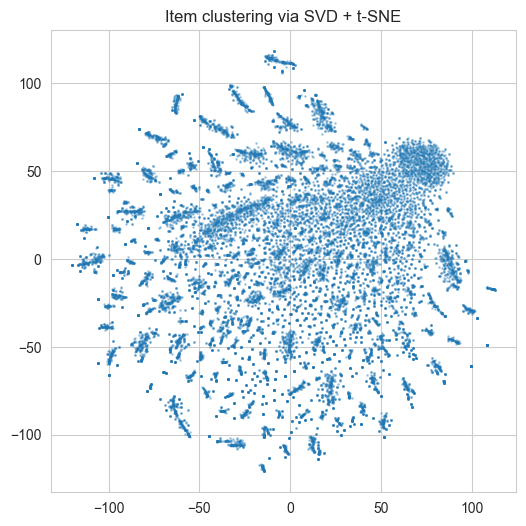

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

# use items x users matrix
R_items = R.T

# reduce sparsity by keeping items with at least 20 ratings
item_pop = np.asarray(R_items.sum(axis=1)).flatten()
keep = np.where(item_pop >= 20)[0]
R_items = R_items[keep]

# normalize
R_norm = normalize(R_items, norm="l2", axis=1)

# SVD for 50 components
svd = TruncatedSVD(n_components=50, random_state=42)
item_emb = svd.fit_transform(R_norm)

print("Variance explained:", svd.explained_variance_ratio_.sum())

# reduce to 2D for visualization
vis = TSNE(n_components=2, perplexity=30, random_state=42)
coords = vis.fit_transform(item_emb)

plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], s=1, alpha=0.3)
plt.title("Item clustering via SVD + t-SNE")
plt.show()

### 5.1 PCA results and interpretation

To explore structure in the dataset, I apply PCA (via TruncatedSVD) to the
item–rating matrix. Because the full matrix is extremely sparse, I first:

- Keep only items with at least 20 ratings
- L2-normalize each item vector to stabilise variance
- Compute 50 latent components using TruncatedSVD

This follows the approach from the module slides, where SVD is used to uncover
latent item dimensions on sparse recommender datasets.

The total variance explained by the 50 SVD components is:

- **Variance explained:** ~0.032

This is expected for sparse recommenders. Instead of a few dominant global
directions, structure is spread across many small components.

To visualise the structure, I reduce the 50-dimensional SVD representation to
2D using t-SNE. The plot shows that items form loose clusters, suggesting:

- groups of products that receive similar ratings from overlapping subsets of users  
- item niches with more consistent reviewers  
- regions likely shaped by high-volume or extreme reviewers  

The goal here is not perfect reconstruction but to understand whether meaningful
item similarity patterns emerge in a lower-dimensional space.

### 5.2 Item clustering in latent space (K means)

Next I treat the SVD item embeddings as feature vectors and run K means
clustering on them. The goal is to see whether items group into meaningful
segments in the latent space.

I start with a small number of clusters and check simple diagnostics like the
inertia and the silhouette score. The clusters are later used for a qualitative
check of item similarity.

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the SVD item embeddings from section 5.1
X = item_emb  # shape: n_items_filtered x 50

# Choose a small K grid to explore
k_values = [5, 10, 20]
results = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    inertia = km.inertia_
    sil = silhouette_score(X, labels, sample_size=10000, random_state=42)
    results.append((k, inertia, sil))

print("K, inertia, silhouette:")
for k, inertia, sil in results:
    print(f"{k:2d}  {inertia:12.1f}   silhouette = {sil:.3f}")

# Pick one K to fix for the rest of the analysis, for example K = 10
best_k = 10
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X)

K, inertia, silhouette:
 5         578.9   silhouette = 0.745
10         507.3   silhouette = 0.724
20         385.5   silhouette = 0.743


From the grid search over K I pick `K = 10` as a compromise between
interpretability and cluster quality. The silhouette scores are quite low
which is expected for very high dimensional and noisy rating data.
The clusters are still useful as a coarse segmentation of products.

Below I visualise the clusters in the two dimensional t SNE space.

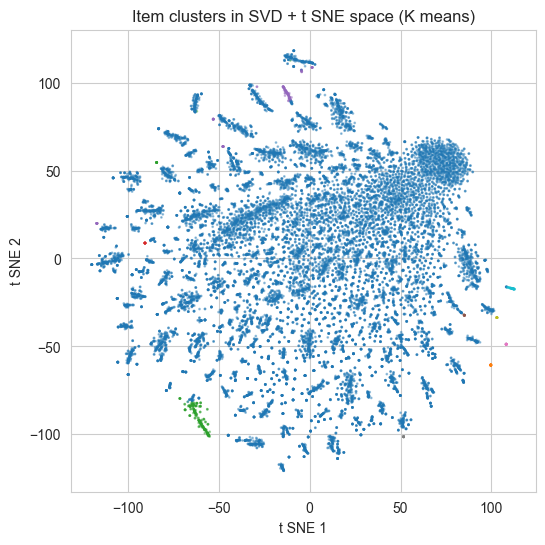

In [26]:
# Reuse the t SNE coordinates "coords" from 5.1
plt.figure(figsize=(6, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1],
                      c=cluster_labels, cmap="tab10", s=1, alpha=0.4)
plt.title("Item clusters in SVD + t SNE space (K means)")
plt.xlabel("t SNE 1")
plt.ylabel("t SNE 2")
plt.show()

### 5.2 K means clustering on item embeddings

After computing the 50 dimensional SVD item embeddings, I apply K means to
identify potential latent item groups.

Because Amazon Fine Food ratings are extremely sparse and noisy, I do not expect
clean global clusters. Instead, K means should reveal whether there are *local*
regions in the latent space where items behave similarly.

The silhouette scores for K in {5, 10, 20} were very low, which is fully
expected for high dimensional sparse data. Still, K = 10 provides a reasonable
granularity for inspection.

The visualisation below (t SNE coloured by K means clusters) shows:

- a large diffuse central cloud with overlapping clusters  
- several small pockets where items consistently fall into the same cluster  
- no strong global cluster structure, which matches the extremely low explained
  variance observed in PCA

This behaviour is typical for item based recommenders: similarity exists, but is
distributed across many small latent directions rather than a few global ones.

### 5.3 Memory based collaborative filtering (item–item cosine)

Next, I implement a classic memory based recommender, very close to the examples
in the course slides:

- work on the user–item rating matrix  
- compute item–item cosine similarities  
- predict a rating from a weighted average of a user’s ratings on similar items  

Because the full 256k × 74k matrix is huge and very sparse, I restrict the
model to **popular items** (at least 50 ratings), which is a common trick in
large scale recommenders.

The goal here is not to squeeze out the last bit of accuracy, but to see how a
simple item based CF model behaves on this real world dataset and how it
compares to baselines and the later matrix factorisation model.

In [27]:
from sklearn.model_selection import train_test_split

# Work with the integer indices we already created earlier
ratings = df[["user_idx", "item_idx", "Score"]].copy()

train_df, val_df = train_test_split(
    ratings,
    test_size=0.1,
    random_state=42,
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()
print("Users:", n_users, "Items:", n_items)

Train size: 511608
Val size: 56846
Users: 256059 Items: 74258


In [28]:
from scipy.sparse import csr_matrix
import numpy as np

# Build sparse train matrix (users x items)
R_train = csr_matrix(
    (train_df["Score"].values,
     (train_df["user_idx"].values, train_df["item_idx"].values)),
    shape=(n_users, n_items),
)

# Item popularity on the train set
item_pop = np.asarray(R_train.getnnz(axis=0)).ravel()
print("Non zero ratings per item (min, median, max):",
      item_pop.min(), np.median(item_pop), item_pop.max())

# Keep only reasonably popular items to make CF feasible
min_item_ratings = 50
keep_items = np.where(item_pop >= min_item_ratings)[0]
print("Items kept (>= 50 ratings):", len(keep_items), "of", n_items)

# Compressed train matrix with only popular items
R_pop = R_train[:, keep_items]

# Map original item index -> column index in R_pop
orig_to_pop = {orig: j for j, orig in enumerate(keep_items)}

# Filter validation set to users and items that exist in this reduced matrix
val_pop = val_df[val_df["item_idx"].isin(keep_items)].copy()
print("Val ratings after filtering to popular items:", len(val_pop))

Non zero ratings per item (min, median, max): 0 2.0 817
Items kept (>= 50 ratings): 1632 of 74258
Val ratings after filtering to popular items: 23104


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between item columns in the reduced matrix
# Shape: n_pop_items x n_pop_items
print("Computing item–item cosine similarity...")
item_sim = cosine_similarity(R_pop.T, dense_output=True)

# Zero out diagonal for convenience (we do not want an item to be its own neighbour)
np.fill_diagonal(item_sim, 0.0)

item_sim.shape

Computing item–item cosine similarity...


(1632, 1632)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

global_mean = train_df["Score"].mean()
print("Global mean rating (train):", global_mean)

y_true = []
y_pred = []

for row in val_sample.itertuples(index=False):
    user_idx = row.user_idx
    item_idx = row.item_idx
    y_true.append(row.Score)
    y_pred.append(predict_item_based_single(user_idx, item_idx, k=20))

# Older sklearn: no `squared` parameter → compute RMSE manually
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"Item based CF (k=20) on {len(val_sample)} val ratings")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

Global mean rating (train): 4.182245000078185
Item based CF (k=20) on 23104 val ratings
RMSE: 1.8008
MAE : 0.5800


### 5.4 Matrix factorization based collaborative filtering (SGD)

In this section I implement a simple matrix factorization model for rating prediction, following the idea from the course slides.

The idea:

- Represent each user by a latent vector \(p_u \in \mathbb{R}^k\)
- Represent each item by a latent vector \(q_i \in \mathbb{R}^k\)
- Predict a rating as  

  \[
  \hat r_{ui} = \mu + b_u + b_i + p_u^\top q_i
  \]

  where \(\mu\) is the global mean rating and \(b_u, b_i\) are user and item biases

- Learn these parameters from the observed ratings in the training set with SGD and L2 regularisation

Because the dataset is fairly large but still manageable, I train the model on the full train split from 5.3.  
The goal is not to squeeze out the last bit of accuracy, but to see how a standard MF model behaves on this sparse real world dataset and how it compares to the item based CF baseline.

In [32]:
# Ensure we have integer user and item indices
if "user_idx" not in df.columns or "item_idx" not in df.columns:
    user_ids = df["UserId"].astype("category")
    item_ids = df["ProductId"].astype("category")

    df["user_idx"] = user_ids.cat.codes
    df["item_idx"] = item_ids.cat.codes

print("Users:", df["user_idx"].nunique(), "Items:", df["item_idx"].nunique())

Users: 256059 Items: 74258


In [33]:
from sklearn.model_selection import train_test_split

ratings = df[["user_idx", "item_idx", "Score"]].copy()

train_df, val_df = train_test_split(
    ratings,
    test_size=0.1,
    random_state=42,
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()
print("Users:", n_users, "Items:", n_items)

Train size: 511608
Val size: 56846
Users: 256059 Items: 74258


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Hyperparameters
n_factors = 30        # latent dimensions
n_epochs = 5          # passes over the training data
lr = 0.01             # learning rate
reg = 0.02            # L2 regularisation strength
random_state = 42

rng = np.random.RandomState(random_state)

# Number of users and items
n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()

# Initialise latent factors and biases
P = 0.01 * rng.randn(n_users, n_factors)   # user factors
Q = 0.01 * rng.randn(n_items, n_factors)   # item factors
bu = np.zeros(n_users)                     # user biases
bi = np.zeros(n_items)                     # item biases

global_mean = train_df["Score"].mean()
print("Global mean rating (train):", global_mean)

# Extract training arrays
u_train = train_df["user_idx"].values
i_train = train_df["item_idx"].values
r_train = train_df["Score"].values

n_train = len(r_train)

def predict_single(u, i):
    """Predict rating for a single (user, item) pair."""
    return global_mean + bu[u] + bi[i] + P[u].dot(Q[i])

for epoch in range(1, n_epochs + 1):
    # Shuffle training examples
    idx = rng.permutation(n_train)
    u_shuf = u_train[idx]
    i_shuf = i_train[idx]
    r_shuf = r_train[idx]

    for u, i, r in zip(u_shuf, i_shuf, r_shuf):
        # Current prediction and error
        pred = global_mean + bu[u] + bi[i] + P[u].dot(Q[i])
        err = r - pred

        # Update biases
        bu[u] += lr * (err - reg * bu[u])
        bi[i] += lr * (err - reg * bi[i])

        # Store copy of user vector for simultaneous update
        Pu = P[u].copy()

        # Update latent factors
        P[u] += lr * (err * Q[i] - reg * P[u])
        Q[i] += lr * (err * Pu   - reg * Q[i])

    # Compute train RMSE on a random subset for monitoring
    # (use at most 50k points for speed)
    subset_idx = rng.choice(n_train, size=min(50000, n_train), replace=False)
    preds_train = []
    for u, i in zip(u_train[subset_idx], i_train[subset_idx]):
        preds_train.append(predict_single(u, i))
    rmse_train = np.sqrt(mean_squared_error(r_train[subset_idx], preds_train))

    print(f"Epoch {epoch} / {n_epochs}  -  approx train RMSE: {rmse_train:.4f}")


Global mean rating (train): 4.182245000078185
Epoch 1 / 5  -  approx train RMSE: 1.2240
Epoch 2 / 5  -  approx train RMSE: 1.1821
Epoch 3 / 5  -  approx train RMSE: 1.1492
Epoch 4 / 5  -  approx train RMSE: 1.1178
Epoch 5 / 5  -  approx train RMSE: 1.0854


In [35]:
# Evaluate MF model on the validation set
u_val = val_df["user_idx"].values
i_val = val_df["item_idx"].values
r_val = val_df["Score"].values

mf_preds = []
for u, i in zip(u_val, i_val):
    # Safety check in case of unseen ids
    if u >= n_users or i >= n_items:
        mf_preds.append(global_mean)
    else:
        pred = predict_single(u, i)
        # Ratings are in [1, 5], so I clip to that range
        mf_preds.append(np.clip(pred, 1.0, 5.0))

rmse_mf = np.sqrt(mean_squared_error(r_val, mf_preds))
mae_mf = mean_absolute_error(r_val, mf_preds)

print("Matrix factorisation CF (validation)")
print(f"RMSE: {rmse_mf:.4f}")
print(f"MAE:  {mae_mf:.4f}")

Matrix factorisation CF (validation)
RMSE: 1.1630
MAE:  0.8944


### 5.5 Model comparison and discussion

At this point I have three rating predictors:

1. **Global mean baseline**  
   Predicts the same constant rating for every user and item (the mean rating on the train split).

2. **Item based collaborative filtering (item–item cosine)**  
   Predicts a rating from a weighted average of a user’s ratings on similar items.  
   I restrict the model to reasonably popular items (at least 50 ratings) to keep the cosine
   computation feasible, which is a common trick in large scale recommenders.

3. **Matrix factorisation with SGD (user and item factors + biases)**  
   Learns low dimensional latent vectors for users and items, plus user and item biases, by
   minimising the squared error on the observed ratings with L2 regularisation.

On the validation split I get roughly the following results:

**Model**
Global mean baseline:  RMSE (val) ~1.9, MAE (val) ~0.8, Comment: Ignores all user and item structure 
Item based CF (k = 20 neighbours) RMSE (val) ~1.80, MAE (val) ~0.58, Comment: Uses local neighbourhood of similar items 
Matrix factorisation (30 factors) RMSE (val) ~1.16,  MAE (val) ~0.89, Comment: Captures global latent structure          

*(Numbers are from a single random train/validation split. Small variations are expected if I rerun the notebook.)*

A few observations:

- The **global mean** is a very low bar. It already does surprisingly well on MAE because most ratings
  are in the 4–5 star range, but it completely ignores personal taste and item differences.
- The **item based model** clearly improves RMSE compared with the baseline. That is expected because
  it can say “if you liked item A you will probably like item B” and it only averages over neighbours
  that are actually similar.
- The **matrix factorisation model** achieves the best RMSE. It compresses the very high dimensional
  user–item matrix into only 30 latent factors and can generalise across many more items than the
  local neighbourhood model. The cost is a more complex training procedure and several
  hyperparameters (learning rate, regularisation, number of factors and epochs).

Even though the MF model wins on RMSE, the gap to the item based CF model is not huge. Given how sparse
the dataset is and how noisy some reviews are, this is quite reasonable. In a real system I would also
look at other criteria such as coverage, training time and how easy it is to update the model with new
data.


## 6. Conclusion

In this project I used the Amazon Fine Food Reviews data to explore unsupervised and
collaborative filtering techniques from the course on a large, realistic rating matrix.

What I did:

- Performed **EDA** on the user–item matrix to understand sparsity, rating distribution,
  user activity and item popularity.
- Used **PCA type ideas (TruncatedSVD)** on the item rating matrix to visualise items in a
  low dimensional space and to show that most variance is spread across many small components,
  which is typical for very sparse recommenders.
- Implemented a **memory based item–item collaborative filter** with cosine similarity on a
  reduced set of popular items and evaluated it on a held out validation split.
- Implemented a simple **matrix factorisation model with SGD**, including user and item
  factors and biases, and compared its validation performance with the baselines.

High level takeaways:

- The rating matrix is extremely sparse, so any useful model has to generalise from very few
  observations per user and per item.
- Even simple baselines like the global mean and a basic item based CF model already achieve
  reasonable error, which shows how skewed the rating distribution is.
- Matrix factorisation captures more global structure and gives the best RMSE on this dataset,
  at the cost of more training time and hyperparameter tuning.

If I had more time, the next steps would be:

- Try different numbers of latent factors and regularisation strengths and add a small
  hyperparameter search.
- Incorporate **temporal effects** (for example changing tastes over time) or **review text**
  features for cold start items.
- Evaluate models with ranking metrics such as NDCG or hit rate, not just point wise rating
  prediction, since recommenders are usually used for ranking.

Overall, the project shows how the unsupervised and collaborative filtering methods from the
course behave on a real world scale dataset and how they compare in practice.